# Simulacion de un dataset de sensado DqR Home

El ambiente a simular se compone de la siguiente manera:

**Dispositivos DqR**
  - 1 x lux-potentia
  - 1 x omni-potentia
  - 1 x potentia-potentia

**Comportamiento simulado**
  - 23hs a 7:00hs: sin actividad
  - 7:00 a 7:30: Preparación para salir
  - 7:30 a 18:30hs: 
      - Día laboral: sin actividad
      - Fin de semana: actividad aleatoria
  - 18:30hs a 19:30hs: actividad aleatoria
  - 19:30 a 23:30hs: actividad con luz prendida
  
**Parámetros de luminosidad del ambiente**
  - Día soleado: 600 lm
  - Día nublado: 300 lm
  - Día nublado + luz: 500 lm
  - Noche: 0-5 lm
  - Noche + luz: 400 lm

## Modelo de DWH

**Dimensiones**
- Tiempo: minutos, día de la semana, estación
- Dispositivo
- Módulo
- Ambiente

**Hechos**
- estado_modulo
- medicion_sonido
- medicion_luz
- medicion_movimiento
- medicion_corriente
- medicion_temperatura


## Configuración inicial

### Import de librerías

In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display
from sklearn.cluster import KMeans
import MySQLdb
import seaborn.apionly as sns
from pandas.io import sql
from sqlalchemy import create_engine

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

### Variables globales

In [60]:
# AÑO a simular
ANIO = 2017

# Config para luminosidad
df_solar = pd.read_excel("dataset_solar.xls")
salida_sol_mins = 30                             # minutos que dura la salida/puesta del sol
prob_nublado = 0.343                             # probabilidad que un dia sea nublado (segun dataset del SMN)
lumenes_noche = 0                                # nivel de luminosidad media durante la noche
lumenes_soleado = 600                            # nivel de luminosidad media durante el dia si esta soleado
lumenes_nublado = 350                            # nivel de luminosidad media durante el dia si esta nublado
lumenes_nublado_luz = 500                        # nivel de luminosidad media durante el dia si esta nublado y la luz prendida
lumenes_lampara = 400                            # nivel de luminosidad media durante la noche con la luz prendida
lumenes_desvio = 25                              # desvio de la media de luminosidad para simular sensado

# Config para presencia
hora_noche_inicio = 1420                         # horario en que se suele ir a dormir (23:40 en minutos)
hora_noche_fin = 420                             # horario en que se suele despertar (7am en minutos)
hora_laboral_inicio = 450                        # horario en que suele ir al trabajo (7:30am en minutos)
hora_laboral_fin = 1110                          # horario en que suele regresar del trabajo (18:30 en minutos)
sonido_silencio_media = 35                       # nivel de sonido medio cuando no hay ruido ambiental
sonido_silencio_desvio = 2                       # desvio estandar del nivel de sonido cuando no hay ruido ambiental
sonido_presencia_media = 60                      # nivel de sonido medio cuando hay presencia
sonido_presencia_desvio = 6                      # desvio estandar del nivel de sonido cuando hay presencia
prob_movimiento_noche = 0.005                    # probabilidad de que se detecte movimiento durante la noche
prob_movimiento_presencia = 0.9                  # probabilidad de que se detecte movimiento cuando hay presencia
movimiento_tiempo_minimo = 5                     # tiempo minimo de activacion del sensor de movimiento (en minutos)

# Config de activacion de lux
prob_lux_on_presencia_dia = 0.1                  # probabilidad de prender la luz durante el dia (con deteccion de presencia)
prob_lux_on_presencia_noche = 0.7                # probabilidad de prender la luz durante la noche (con deteccion de presencia)
prob_lux_on_sinpresencia_dia = 0.01              # probabilidad de prender la luz durante el dia (sin deteccion de presencia)
prob_lux_on_sinpresencia_noche = 0.03            # probabilidad de prender la luz durante la noche (sin deteccion de presencia)
media_lumenes_limite_prendido = 150              # limite de nivel de luz para prender la luz (media)
desvio_lumenes_limite_prendido = 20              # limite de nivel de luz para prender la luz (desvio)

# Config para temperatura
df_temp = pd.read_csv("dataset_meteorologico.csv",delimiter=';',decimal=',')

# Variables de tipos de sensores
LIGHT_SENSOR_TYPE = 2
ACS_SENSOR_TYPE = 1
MOVEMENT_SENSOR_TYPE = 3
SOUND_SENSOR_TYPE = 4
TEMP_SENSOR_TYPE = 5


### Datos de conexión a la base de datos del ratio

In [61]:
# Base de datos Consola Ratio
dbname = "ratio_dev_eric"
dbhost = "localhost"
dbport = 3306
dbuser = "root"
dbpass = "root"

# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"
table_hist = "events_hist"
device_events_tbl = "device_events"
device_event_sensors_tbl = "device_event_sensors"

## Funciones

Las siguientes funciones generan datos simulados para un día

### Generar Estructura del año
Devuelve un dataframe con las columnas básicas de la dimensión tiempo

In [62]:
def generar_estructura_anio(anio=ANIO):
    fechas_mins = pd.date_range('1/1/'+str(anio),'1/1/'+str(anio+1), freq='Min')[:-1]
    df_general = pd.DataFrame(fechas_mins,columns=['TIMESTAMP'])
    df_general['YEARDAY'] = df_general['TIMESTAMP'].dt.strftime('%j').astype(int)
    df_general['WEEKDAY'] = df_general['TIMESTAMP'].dt.weekday
    df_general['HOUR'] = df_general['TIMESTAMP'].dt.hour
    df_general['MINUTE'] = df_general['TIMESTAMP'].dt.minute
    df_general['MINDAY'] = df_general['HOUR'] * 60 + df_general['MINUTE']
    return df_general

def generar_estructura_anio_oldschool(anio=ANIO):
    inicio = '01-01-' + str(anio)
    fecha = datetime.strptime(inicio,'%d-%m-%Y')
    df_general = []
    while (anio == fecha.year):
        yearday = int(fecha.strftime('%j'))
        weekday = fecha.weekday()
        dia = [ {'YEARDAY': yearday, 'WEEKDAY': weekday, 'MINDAY': x, 'HOUR': x/60, 'MINUTE': x%60 } for x in range(0,1440) ]
        df_general = df_general + dia
        fecha = fecha + timedelta(days=1)
    return pd.DataFrame.from_records(df_general, columns=['YEARDAY','WEEKDAY','MINDAY','HOUR','MINUTE'])

### Generar día de luminosidad
Se define la funcion generar_luminosidad que acepta como argumento el dia del año. Se retorna un dataframe con los 1440 minutos del dia con la simulacion de la luz acorde a la salida y puesta del sol y con una probabilidad de lluvia.

In [63]:
def generar_luminosidad(dia):
    #np.random.seed(13)
    salidaH = df_solar.iloc[dia-1].SALIDA_HORA
    salidaM = df_solar.iloc[dia-1].SALIDA_MIN
    min_salida = salidaH * 60 + salidaM
    puestaH = df_solar.iloc[dia-1].PUESTA_HORA
    puestaM = df_solar.iloc[dia-1].PUESTA_MIN
    min_puesta = puestaH * 60 + puestaM
    
    luz_dia = lumenes_nublado if np.random.binomial(1,prob_nublado) == 1 else lumenes_soleado
    
    result = np.random.randint(6, size=1440)
    
    ultimo = result[min_salida]
    for min in range(salida_sol_mins):
        result[min_salida + min] = ultimo + luz_dia / salida_sol_mins
        ultimo += luz_dia / salida_sol_mins
    result[min_salida + salida_sol_mins:min_puesta + 1] = np.random.normal(luz_dia,lumenes_desvio,min_puesta+1-min_salida-salida_sol_mins)
    for min in range(salida_sol_mins):
        result[min_puesta + min] = abs(ultimo - luz_dia / salida_sol_mins)
        ultimo -= luz_dia / salida_sol_mins
    return result

### Generar día de presencia
Se simulan los sensores de sonido y movimiento segun la probabilidad de presencia en el ambiente por franja horaria, según el día especificado (laboral o fin de semana)

In [64]:
def generar_presencia(laboral=True):
    sonido_base = np.random.normal(sonido_silencio_media,sonido_silencio_desvio,1440)
    movimiento_base = np.random.binomial(1,prob_movimiento_noche,1440)
    
    if laboral:
        movimiento_base[hora_noche_fin:hora_laboral_inicio+1] = np.random.binomial(1,prob_movimiento_presencia,hora_laboral_inicio-hora_noche_fin+1)
        movimiento_base[hora_laboral_fin:hora_noche_inicio+1] = np.random.binomial(1,prob_movimiento_presencia,hora_noche_inicio-hora_laboral_fin+1)
    else:
        movimiento_base[hora_noche_fin:hora_noche_inicio+1] = np.random.binomial(1,prob_movimiento_presencia,hora_noche_inicio-hora_noche_fin+1)
        
    # Suavizado de movimiento (y ajustando tambien el de sonido para correlacionarlo)
    min = 0
    while min < 1440:
        if movimiento_base[min] == 1:
            last_min = min + movimiento_tiempo_minimo if min + movimiento_tiempo_minimo < 1440 else 1440
            movimiento_base[min:last_min] = 1
            sonido_base[min:last_min] = np.random.normal(sonido_presencia_media,sonido_presencia_desvio,last_min-min)
            min = last_min
        min += 1
        
    return pd.DataFrame(pd.Series(sonido_base),columns=['SONIDO']).join(pd.DataFrame(pd.Series(movimiento_base),columns=['MOVIMIENTO']))

### Generar año de consumo de heladera
Se utilizan las estimaciones obtenidas de la preparación de datos para generar una lista aleatoria de consumo del año configurado.
Entonces se devuelve una lista que contiene el consumo de una heladera para todos los minutos del año.

In [65]:
def generar_consumo_heladera(parametros_consumo,anio=ANIO):
    # parametros_consumo es una lista que contiene los siguientes datos:
    tiempo_heladera_on_media = parametros_consumo[0]
    tiempo_heladera_on_desvio = parametros_consumo[1]
    tiempo_heladera_off_media = parametros_consumo[2]
    tiempo_heladera_off_desvio = parametros_consumo[3]
    heladera_consumo_on_media = parametros_consumo[4]
    heladera_consumo_on_desvio = parametros_consumo[5]
    heladera_consumo_off_media = parametros_consumo[6]
    heladera_consumo_off_desvio = parametros_consumo[7]
    
    ultimo_min = datetime.strptime('31-12-'+str(anio),'%d-%m-%Y').timetuple().tm_yday * 1440
    minuto_inicio = 0
    df_heladera_anio = []
    ultimo_periodo = 'on'
    while minuto_inicio < ultimo_min:
        periodo_off = abs(int(np.random.normal(tiempo_heladera_off_media, tiempo_heladera_off_desvio)))
        periodo_on = abs(int(np.random.normal(tiempo_heladera_on_media, tiempo_heladera_on_desvio)))
    
        if ultimo_periodo == 'off':
            # generacion de periodo de encendido
            consumo_media = heladera_consumo_on_media
            consumo_desvio = heladera_consumo_on_desvio
            periodo_mins = periodo_on
            ultimo_periodo = 'on'
        else:
            # generacion de periodo de apagado
            consumo_media = heladera_consumo_off_media
            consumo_desvio = heladera_consumo_off_desvio
            periodo_mins = periodo_off
            ultimo_periodo = 'off'
        
        df_heladera_anio[minuto_inicio:minuto_inicio+periodo_mins] =  [x if x >= 0 else 0 for x in np.random.normal(consumo_media, consumo_desvio, size=periodo_mins+1)]
        minuto_inicio += periodo_mins
    return df_heladera_anio[0:ultimo_min]

## Preparación de datos
En principio se trabajan algunos datasets utilizados para la simulación final

### Preparación de variables de consumo de Lux (media y desvío)
Se utiliza las mediciones reales de iluminacion de la cocina para calcular valores medios y desvios de consumo de la misma. El resultado serán la media y desvío de consumo de la lámpara asociada al Lux cuando está prendida y apagada.

In [66]:
# Estrayendo valores de sensado del modulo Lux (51) despues del 18/10
conn = MySQLdb.connect(host=dbhost, port=dbport, user=dbuser, passwd=dbpass, db=dbname)
df_lux_consumo = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=51 and sensor_type_id = 1 and ts > "2017-10-18"', con=conn)
#df_lux_consumo = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=51 and sensor_type_id = 1', con=conn)
conn.close()

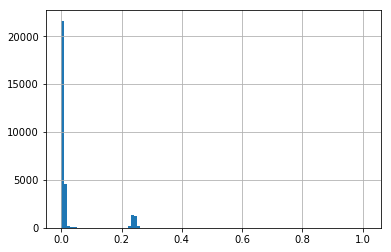

In [67]:
df_lux_consumo.value.hist(bins=100)

Utilizando kmeans se puede analizar la distribucion bimodal para sacar las medias y desvios de cada estado (on/off)

In [68]:
# Se entrena para clusterizar (consumo luz prendida | consumo luz apagada)
kmeans = KMeans(n_clusters=2).fit(df_lux_consumo.value.values.reshape(-1,1))

# Calculo de las medias (centros de los clusters)
media_luz_off = kmeans.cluster_centers_[0][0]  # media de consumo cuando esta la luz apagada
media_luz_on = kmeans.cluster_centers_[1][0]   # media de consumo cuando esta la luz prendida

# Para calcular el desvio se encuentra el punto límite de clasificación y se computan los std de cada grupo
for i in range(100,1500):
    if kmeans.predict(i/1000.0) == 1:
        limite_consumo_on = i/1000.0
        break
desvio_luz_off = df_lux_consumo[ df_lux_consumo.value < limite_consumo_on ]['value'].std()
desvio_luz_on = df_lux_consumo[ df_lux_consumo.value > limite_consumo_on ]['value'].std()

### Preparación de variables de consumo de heladera (media y desvío)
Se analizan los datos reales del consumo de la heladera para simularlo a lo largo del año

In [69]:
# Estrayendo valores de sensado del modulo Pot (61) despues del 21/10
conn = MySQLdb.connect(host=dbhost, port=dbport, user=dbuser, passwd=dbpass, db=dbname)
df_heladera_consumo = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=61 and sensor_type_id = 1 and ts > "2017-10-21"', con=conn)
conn.close()

In [70]:
df_heladera_consumo['MINUTO_DIA'] = df_heladera_consumo.ts.dt.hour * 60 +  df_heladera_consumo.ts.dt.minute  # Se genera la dimension MINUTO_DIA

Se selecciona un intervalo de medición contínua para determinar mejor el patrón de consumo

In [71]:
df_heladera_consumo [df_heladera_consumo.MINUTO_DIA.diff() > 2]

,ts,value,MINUTO_DIA
1,2017-10-21 17:25:57,0.0644,1045
4,2017-10-21 17:30:44,0.3085,1050
5,2017-10-21 17:44:05,0.0011,1064
9,2017-10-21 18:01:12,0.8285,1081
1009,2017-10-22 10:43:03,0.0020,643
1021,2017-10-22 10:57:03,0.7802,657
1022,2017-10-22 19:47:26,0.0000,1187
1030,2017-10-22 20:01:24,0.0000,1201
1035,2017-10-22 20:35:05,0.0000,1235
1042,2017-10-22 20:52:56,0.0000,1252


In [72]:
df_heladera_consumo = df_heladera_consumo.iloc[5876:7305]     # Se selecciona un intervalo de medicion continua

In [73]:
df_heladera_consumo.describe()

,value,MINUTO_DIA
count,1429.000000,1429.000000
mean,0.350364,723.377887
std,0.386867,414.705981
min,0.000000,0.000000
25%,0.001800,368.000000
50%,0.005500,724.000000
75%,0.723200,1081.000000
max,5.029100,1439.000000


Se calculan las media y desvio del consumo y del tiempo que está prendida y apagada la heladera

In [74]:
df_heladera_consumo = df_heladera_consumo.assign(ESTADO = 0)
df_heladera_consumo = df_heladera_consumo.assign(CAMBIO_ESTADO = 0)
df_heladera_consumo.loc[ df_heladera_consumo.value > 0.2, 'ESTADO'] = 1
df_heladera_consumo['CAMBIO_ESTADO'] = df_heladera_consumo.ESTADO.diff()

# Consumo de la heladera (media y desvio)
heladera_consumo_on_media = df_heladera_consumo.query('ESTADO == 1').value.mean()
heladera_consumo_on_desvio = df_heladera_consumo.query('ESTADO == 1').value.std()
heladera_consumo_off_media = df_heladera_consumo.query('ESTADO == 0').value.mean()
heladera_consumo_off_desvio = df_heladera_consumo.query('ESTADO == 0').value.std()

# Periodos en que estuvo prendida o apagada la heladera
periodo_heladera = pd.DataFrame(df_heladera_consumo[ (df_heladera_consumo.CAMBIO_ESTADO == -1) | (df_heladera_consumo.CAMBIO_ESTADO == 1) ][1:].ts.diff().dt.seconds/60)
periodo_heladera.rename(columns = {'ts':'PERIODO_MINUTOS'}, inplace=True)
heladera_tiempo_media = periodo_heladera.PERIODO_MINUTOS.mean()
heladera_tiempo_desvio = periodo_heladera.PERIODO_MINUTOS.std()

# Se agregan los datos medidos para definir periodos de prendida y apagada
periodo_heladera = periodo_heladera.join(df_heladera_consumo, rsuffix='_raw')
periodo_heladera_prendida = periodo_heladera.query('CAMBIO_ESTADO == -1')
periodo_heladera_apagada = periodo_heladera.query('CAMBIO_ESTADO == 1')

Entonces así se pueden calcular una estimación de tiempos en minutos durante los cuales la heladera está prendida y apagada.

In [75]:
tiempo_heladera_on_media = periodo_heladera_prendida[ periodo_heladera_prendida.PERIODO_MINUTOS.notnull() ].PERIODO_MINUTOS.mean()
tiempo_heladera_on_desvio = periodo_heladera_prendida[ periodo_heladera_prendida.PERIODO_MINUTOS.notnull() ].PERIODO_MINUTOS.std()

In [76]:
tiempo_heladera_off_media = periodo_heladera_apagada[ periodo_heladera_apagada.PERIODO_MINUTOS.notnull() ].PERIODO_MINUTOS.mean()
tiempo_heladera_off_desvio = periodo_heladera_apagada[ periodo_heladera_apagada.PERIODO_MINUTOS.notnull() ].PERIODO_MINUTOS.std()

Finalmente armo una lista con todos los parametros de consumo para generar luego en la simulacion

In [77]:
parametros_consumo_heladera = [tiempo_heladera_on_media,
                               tiempo_heladera_on_desvio,
                               tiempo_heladera_off_media,
                               tiempo_heladera_off_desvio,
                               heladera_consumo_on_media,
                               heladera_consumo_on_desvio,
                               heladera_consumo_off_media,
                               heladera_consumo_off_desvio]

### Preparación de valores de temperatura
Se utilizan datos del servicio meteorologico correspondientes al año 2011 y 2012, promediando la temperatura registrada por todos los sensores en funcionamiento para cada hora. El resultado será un dataframe del año completo limpio y listo para mergear en el dataframe general simulado.

Limpieza del dataset meteorologico

In [78]:
df_temp['FECHA'] = pd.to_datetime(df_temp['FECHA'],errors='coerce')   # se cambia el tipo de dato FECHA
df_temp = df_temp[df_temp['FECHA'].notnull()]                         # elimina las fechas invalidas (como el 29 de febrero)
df_temp = df_temp.query('TEMP_C != 1802.6')                           # Se limpian temperaturas espurias
df_temp['DIA_ANIO'] = df_temp['FECHA'].dt.strftime('%j').astype(int)  # Se genera la dimension DIA_ANIO
df_temp['MES'] = df_temp['FECHA'].dt.month                            # Se genera la dimension MES
df_temp['HORA'] = pd.to_datetime(df_temp.HORA).dt.hour                # Se transforma la dimension HORA a entero

Se genera un nuevo dataframe con solo los campos DIA, HORA y TEMP. Los dos primeros se usaran para mergear en el dataframe general

In [79]:
df_temp_grouped = pd.DataFrame(df_temp.groupby(['DIA_ANIO','HORA'],as_index=False).TEMP_C.mean())

Comprobación que el groupby con medias fue correcto:

In [80]:
pd.DataFrame(df_temp.groupby(['DIA_ANIO','HORA']).TEMP_C.mean()).query('DIA_ANIO == 78 & HORA == 22')

,,TEMP_C
DIA_ANIO,HORA,
78,22,21.133333


In [81]:
df_temp_grouped.iloc[1720]

DIA_ANIO    78.000000
HORA        22.000000
TEMP_C      21.133333
Name: 1720, dtype: float64

## Analizando datos reales de medicion
Como los datos medidos no alcanzan para realizar un análisis completo se genera el dataset simulado al final. De todas formas, hacemos un analisis parcial de los datos hasta el momento para detectar una relación entre condiciones del ambiente y así preparar una simulación basada en ello.

### Ejecución de queries para obtener datos (extracción)

In [82]:
# Estrayendo valores de estado y sensado del modulo Lux (51)
conn = MySQLdb.connect(host=dbhost, port=dbport, user=dbuser, passwd=dbpass, db=dbname)
df_lux_estado = pd.read_sql('select ts, max(state) as state from device_events where module_id=51 group by ts', con=conn)
df_lux_consumo = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=51 and sensor_type_id = 1', con=conn)
df_lux_movimiento = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=51 and sensor_type_id = 3', con=conn)
df_lux_sonido = pd.read_sql('select ts, value from device_events d join device_event_sensors s on d.id=s.device_event_id where module_id=51 and sensor_type_id = 4', con=conn)
conn.close()

### Limpieza de datos y generación de nuevas variables
Una vez obtenidos los datos del modulo 51 (lux) separados por sensor, se procede a unirlos en un dataframe unico para analizar la correlacion entre las variables. Tambien se genera la dimension ESTADO_LUZ para indicar si la luz esta prendida o apagada.

In [83]:
df_lux_dwh = pd.merge(df_lux_estado, df_lux_consumo,  how='left', on='ts')
df_lux_dwh = pd.merge(df_lux_dwh, df_lux_movimiento,  how='left', on='ts', suffixes=('_consumo','_movimiento'))
df_lux_dwh = pd.merge(df_lux_dwh, df_lux_sonido,  how='left', on='ts')
df_lux_dwh.rename(columns = {'value':'value_sonido'}, inplace=True)
df_lux_dwh['DIA_SEMANA'] = df_lux_dwh['ts'].dt.weekday
df_lux_dwh['HORA'] = df_lux_dwh['ts'].dt.hour
df_lux_dwh['MIN_DIA'] = df_lux_dwh['HORA'] * 60 + df_lux_dwh['ts'].dt.minute
df_lux_dwh = df_lux_dwh.assign(ESTADO_LUZ = 0)
df_lux_dwh.loc[(df_lux_dwh.state == 1) | (df_lux_dwh.state == 3),'ESTADO_LUZ'] = 1

Se utiliza un corte del dataframe para utilizar rango de fechas donde no hubo operacion anomala. En este caso desde el 18/10.

In [84]:
df_lux_dwh_cut = df_lux_dwh[ (df_lux_dwh.ts > datetime.strptime('18-10-2017','%d-%m-%Y')) ]

### Análisis multivariado

In [85]:
df_lux_dwh_cut.corr()

,state,value_consumo,value_movimiento,value_sonido,DIA_SEMANA,HORA,MIN_DIA,ESTADO_LUZ
state,1.000000,0.970989,0.413232,0.176452,-0.054497,0.133223,0.132963,0.997834
value_consumo,0.970989,1.000000,0.432373,0.175031,-0.061338,0.131624,0.131159,0.972255
value_movimiento,0.413232,0.432373,1.000000,0.224732,-0.036132,0.192612,0.192807,0.412880
value_sonido,0.176452,0.175031,0.224732,1.000000,-0.012154,0.084337,0.084358,0.175885
DIA_SEMANA,-0.054497,-0.061338,-0.036132,-0.012154,1.000000,-0.004020,-0.004301,-0.054782
HORA,0.133223,0.131624,0.192612,0.084337,-0.004020,1.000000,0.999128,0.132039
MIN_DIA,0.132963,0.131159,0.192807,0.084358,-0.004301,0.999128,1.000000,0.131735
ESTADO_LUZ,0.997834,0.972255,0.412880,0.175885,-0.054782,0.132039,0.131735,1.000000


La correlacion entre estado y el consumo es practicamente lineal, lo cual es correcto que asi sea. Por lo tanto no se toma en cuenta para predecir el estado. Se crearan nuevas variables de tipo ordinal para discretizar un poco las continuas y mejorar el modelo.

Se discretiza la variable sonido en una que represente el nivel dividido en niveles de 10db. **(Por el momento esto no da bien porque el sensor no mide niveles reales, por eso el rango empieza en 30)**

In [86]:
#df_lux_dwh_cut['NIVEL_SONIDO'] = pd.qcut(df_lux_dwh_cut.value_sonido,5,labels=False)
df_lux_dwh_cut['NIVEL_SONIDO'] = pd.cut(df_lux_dwh_cut.value_sonido,range(30,130,10),labels=False,include_lowest=True)

Se agrega una variable que puede servir para otro tipo de modelo: 
- CAMBIO_ESTADO. Esta variable detecta cuando se prende o apaga la luz
    - -1: La luz se apago
    -  0: No hay cambio de estado
    -  1: La luz se prendio

In [87]:
df_lux_dwh_cut.assign(CAMBIO_ESTADO = 0)
df_lux_dwh_cut['CAMBIO_ESTADO'] = df_lux_dwh_cut.ESTADO_LUZ.diff()

#### Relación entre las variables categoricas contra el ESTADO_LUZ

- Tabla de contingencia para ESTADO_LUZ - HORA (en porcentajes)

In [88]:
pd.crosstab(df_lux_dwh_cut.ESTADO_LUZ,df_lux_dwh_cut.HORA,normalize='columns')*100

HORA,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ESTADO_LUZ,,,,,,,,,,,,,,,,,,,,,
0,66.564417,84.94832,84.525447,94.875776,93.82716,100.0,100.0,100.0,100.0,100.0,...,99.857955,98.488665,95.611814,96.750232,92.980857,97.82197,81.818182,76.282051,66.196078,43.531977
1,33.435583,15.05168,15.474553,5.124224,6.17284,0.0,0.0,0.0,0.0,0.0,...,0.142045,1.511335,4.388186,3.249768,7.019143,2.17803,18.181818,23.717949,33.803922,56.468023


- Tabla de proporción de ESTADO_LUZ según hora del día y día de la semana (0: lunes, 6: domingo)

In [89]:
estado_luz_pvt = pd.pivot_table(df_lux_dwh_cut, values="ESTADO_LUZ",index=["DIA_SEMANA"], columns=["HORA"], fill_value=0)
estado_luz_pvt

HORA,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DIA_SEMANA,,,,,,,,,,,,,,,,,,,,,
0,0.296296,0.045802,0.016260,0.040984,0.000000,0,0,0,0,0,...,0.000000,0.007576,0.00000,0.000000,0.000000,0.000000,0.161290,0.288372,0.497561,0.631868
1,0.297872,0.333333,0.377049,0.068702,0.336634,0,0,0,0,0,...,0.000000,0.000000,0.00000,0.102941,0.201389,0.000000,0.000000,0.000000,0.203252,0.461078
2,0.223776,0.065104,0.234483,0.058140,0.000000,0,0,0,0,0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.304183,0.516129,0.825397,0.860317
3,0.312500,0.174419,0.175287,0.007273,0.012448,0,0,0,0,0,...,0.006826,0.000000,0.00000,0.000000,0.333333,0.190083,0.169355,0.043243,0.111111,0.484375
4,0.329480,0.037879,0.000000,0.007519,0.000000,0,0,0,0,0,...,0.000000,0.000000,0.00000,0.151079,0.043478,0.000000,0.388489,0.288732,0.029126,0.736486
5,0.508021,0.196809,0.106952,0.183784,0.000000,0,0,0,0,0,...,0.000000,0.093407,0.27957,0.000000,0.000000,0.000000,0.000000,0.189560,0.263415,0.440217
6,0.472527,0.211640,0.027624,0.000000,0.048913,0,0,0,0,0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.178218,0.193798,0.086420,0.164894


- Mapa de calor de luz prendida según hora y día de la semana

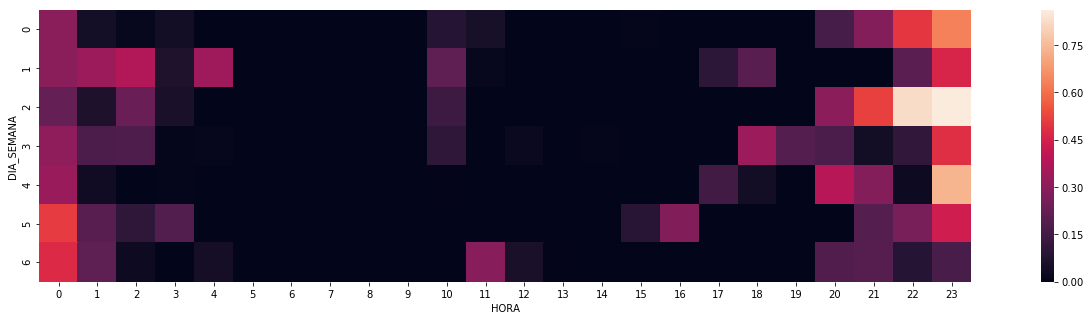

In [90]:
plt.figure(figsize=(25, 5))
ax = sns.heatmap(estado_luz_pvt, square=True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.show()

#### Análisis de variables MOVIMIENTO y SONIDO con ESTADO_LUZ

In [91]:
# Tablas de contingencia para MOVIMIENTO-ESTADO para la noche y el dia
estado_mov_tab_noche = pd.crosstab(df_lux_dwh_cut.query('HORA < 8 | HORA > 20').ESTADO_LUZ,df_lux_dwh_cut.value_movimiento,normalize='columns')*100
estado_mov_tab_noche

value_movimiento,0.0,1.0
ESTADO_LUZ,,
0.0,96.434053,50.549451
1.0,3.565947,49.450549


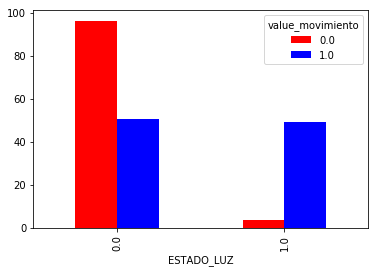

In [92]:
estado_mov_tab_noche.plot(kind='bar', stacked=False, color=['red','blue'], grid=False)

In [93]:
estado_mov_tab_dia = pd.crosstab(df_lux_dwh_cut.query('HORA > 7 & HORA < 21').ESTADO_LUZ,df_lux_dwh_cut.value_movimiento,normalize='columns')*100
estado_mov_tab_dia

value_movimiento,0.0,1.0
ESTADO_LUZ,,
0.0,99.469276,89.176562
1.0,0.530724,10.823438


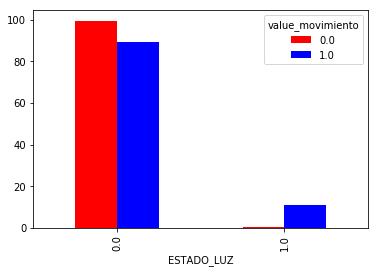

In [94]:
estado_mov_tab_dia.plot(kind='bar', stacked=False, color=['red','blue'], grid=False)

In [95]:
df_lux_dwh_cut.query('HORA < 8 | HORA > 20').ESTADO_LUZ.value_counts()

0    13028
1     2690
Name: ESTADO_LUZ, dtype: int64

In [96]:
pd.crosstab(df_lux_dwh_cut.ESTADO_LUZ,[df_lux_dwh_cut.value_movimiento,df_lux_dwh_cut.NIVEL_SONIDO])

value_movimiento    0.0                   1.0                                \
NIVEL_SONIDO        0.0 1.0 2.0 3.0 4.0   0.0  1.0  2.0 3.0 4.0 5.0 6.0 7.0   
ESTADO_LUZ                                                                    
0                 22590  77   5   0   2  5573  535  159   5  91  33  22   1   
1                   441   8   4   2   0  2010  451  153  13  96  34  19   2   

value_movimiento      
NIVEL_SONIDO     8.0  
ESTADO_LUZ            
0                  6  
1                  7

In [97]:
pd.crosstab(df_lux_dwh_cut.ESTADO_LUZ,[df_lux_dwh_cut.value_movimiento,df_lux_dwh_cut.NIVEL_SONIDO]).apply(lambda r: r/r.sum()*100, axis=0)

value_movimiento       0.0                                           1.0  \
NIVEL_SONIDO           0.0        1.0        2.0    3.0    4.0       0.0   
ESTADO_LUZ                                                                 
0                 98.08519  90.588235  55.555556    0.0  100.0  73.49334   
1                  1.91481   9.411765  44.444444  100.0    0.0  26.50666   

value_movimiento                                                         \
NIVEL_SONIDO            1.0        2.0        3.0        4.0        5.0   
ESTADO_LUZ                                                                
0                 54.259635  50.961538  27.777778  48.663102  49.253731   
1                 45.740365  49.038462  72.222222  51.336898  50.746269   

value_movimiento                                   
NIVEL_SONIDO            6.0        7.0        8.0  
ESTADO_LUZ                                         
0                 53.658537  33.333333  46.153846  
1                 46.341463  66.666667  53.846154

## Probando performance...
Algunas pruebas de performance según se trabaje con distintos tipos de datos

In [98]:
%time generar_estructura_anio_oldschool().head(1)

Wall time: 8.87 s


,YEARDAY,WEEKDAY,MINDAY,HOUR,MINUTE
0,1,6,0,0,0


In [99]:
%time generar_estructura_anio().head(1)

Wall time: 4.62 s


,TIMESTAMP,YEARDAY,WEEKDAY,HOUR,MINUTE,MINDAY
0,2017-01-01,1,6,0,0,0


### Simulación de luminosidad

Wall time: 2 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AD6A588>]], dtype=object)

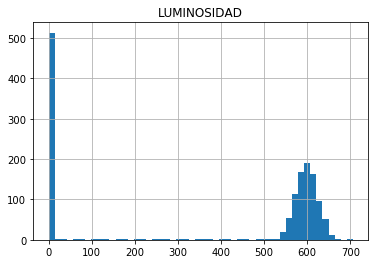

In [100]:
%time df_luz = pd.DataFrame(pd.Series(generar_luminosidad(350)),columns=['LUMINOSIDAD'])
df_luz.hist(bins=50)

### Simulación de presencia

Wall time: 4 ms


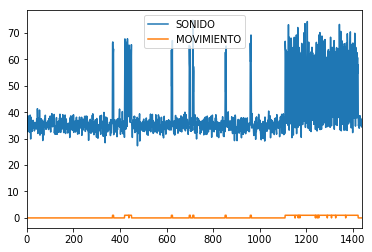

In [101]:
%time presencia = generar_presencia(True)
presencia.plot(presencia.index.values,['SONIDO','MOVIMIENTO'])

In [102]:
#display(presencia.MOVIMIENTO.value_counts().plot(kind='bar', stacked=False, color=['red','blue'], grid=False))

## Simulación y generación del dataset
Se genera un dataset completo del año con las funciones y datasets previos

In [103]:
#inicializamos el dataset general
df_general = generar_estructura_anio()
df_general.dtypes

TIMESTAMP    datetime64[ns]
YEARDAY               int32
WEEKDAY               int64
HOUR                  int64
MINUTE                int64
MINDAY                int64
dtype: object

### Merge de temperaturas
Se agregan datos de temperatura al dataset general (join y limpieza)

In [104]:
df_general = pd.merge(df_general, df_temp_grouped,  how='left', left_on=['YEARDAY','HOUR'], right_on = ['DIA_ANIO','HORA'])
df_general.drop(['DIA_ANIO','HORA'], axis=1, inplace=True)
df_general.rename(columns = {'TEMP_C':'TEMPERATURE'}, inplace=True)

### Simulación de luminosidad, sonido y movimiento
Se utilizan las funciones definidas previamente para generar datos simulados para cada día del año

In [105]:
df_general = df_general.assign(LIGHT = np.nan)
df_general = df_general.assign(SOUND = np.nan)
df_general = df_general.assign(MOVEMENT = np.nan)
for dia in range(1,366):
    fecha_actual = fecha = datetime.strptime('01-01-'+str(ANIO), '%d-%m-%Y') + timedelta(dia - 1)
    minuto_inicio = (dia - 1) * 1440
    minuto_fin = dia * 1440 - 1
    
    # agregamos datos de luminosidad
    luminosidad = generar_luminosidad(dia)
    df_general.loc[minuto_inicio:minuto_fin,'LIGHT'] = luminosidad

    # generamos datos de presencia (movimiento y sonido)
    presencia = generar_presencia(fecha_actual.weekday() != 6 and fecha_actual.weekday() != 5)
    df_general.loc[minuto_inicio:minuto_fin,'SOUND'] = presencia['SONIDO'].values
    df_general.loc[minuto_inicio:minuto_fin,'MOVEMENT'] = presencia['MOVIMIENTO'].values    

### Simulación de activación de la luz
Se consideran las variables de probabilidad configuradas para generar estados de encendido y apagado de la luz según el momento del día (iluminación ambiente) y el movimiento detectado

In [106]:
# Se agrega simulación de activación de la luz (luz prendida o apagada)
luz_minima_activacion = np.random.normal(media_lumenes_limite_prendido, desvio_lumenes_limite_prendido, size=df_general.shape[0])
df_general = df_general.assign(LUX_ON = False)

# Genera activación de la luz durante la noche (con y sin movimiento)
df_general.loc[ ((df_general.LIGHT < luz_minima_activacion) & (df_general.MOVEMENT == 1)) ,'LUX_ON'] = np.random.binomial(1,prob_lux_on_presencia_noche,size=df_general.shape[0])
df_general.loc[ ((df_general.LIGHT < luz_minima_activacion) & (df_general.MOVEMENT == 0)) ,'LUX_ON'] = np.random.binomial(1,prob_lux_on_sinpresencia_noche,size=df_general.shape[0])

# Genera activación de la luz durante el dia (con y sin movimiento)
df_general.loc[ ((df_general.LIGHT >= luz_minima_activacion) & (df_general.MOVEMENT == 1)) ,'LUX_ON'] = np.random.binomial(1,prob_lux_on_presencia_dia,size=df_general.shape[0])
df_general.loc[ ((df_general.LIGHT >= luz_minima_activacion) & (df_general.MOVEMENT == 0)) ,'LUX_ON'] = np.random.binomial(1,prob_lux_on_sinpresencia_dia,size=df_general.shape[0])

# Se agrega la variable de consumo del Lux
df_general = df_general.assign(LUX_ACS = np.nan)
df_general.loc[ df_general.LUX_ON == 1, 'LUX_ACS' ] = abs(np.random.normal(media_luz_on, desvio_luz_on,size=df_general.shape[0]))
df_general.loc[ df_general.LUX_ON == 0, 'LUX_ACS' ] = abs(np.random.normal(media_luz_off, desvio_luz_off,size=df_general.shape[0]))

# Se agrega el sensado de luminosidad según se prende o apaga la luz (variable separada para evitar perder info)
luz_variable_dia_nublado = np.random.normal(lumenes_nublado, lumenes_desvio, size=df_general.shape[0])
df_general['LIGHT_LUX'] = df_general.LIGHT
df_general.loc[ (df_general.LUX_ON == 1) & (df_general.LIGHT_LUX < luz_minima_activacion), 'LIGHT_LUX' ] = np.random.normal(lumenes_lampara ,lumenes_desvio, size=df_general.shape[0])
df_general.loc[ (df_general.LUX_ON == 1) & (df_general.LIGHT_LUX < luz_variable_dia_nublado), 'LIGHT_LUX' ] = np.random.normal(lumenes_nublado_luz ,lumenes_desvio, size=df_general.shape[0])

### Simulación de consumo de Potentia (heladera)
Se utilizan los parametros de consumo estimados del consumo real de la db y se genera una simulación

In [107]:
df_general = df_general.assign(POT_ACS = generar_consumo_heladera(parametros_consumo_heladera))

## Validando datos simulados...
- Mapa de calor de luz prendida según hora y día de la semana

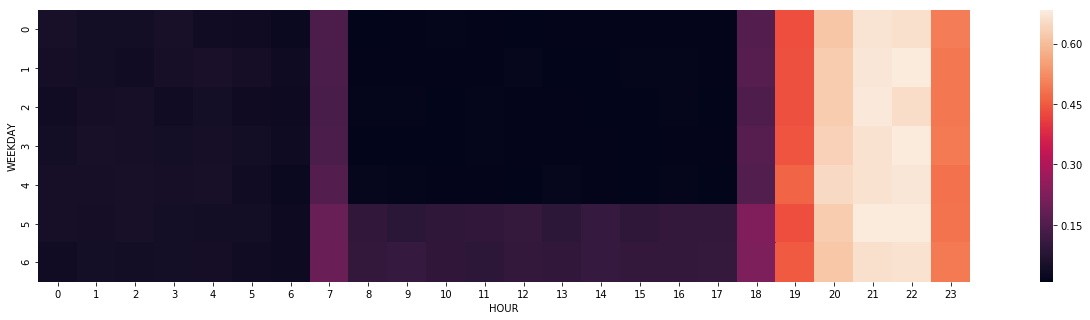

In [108]:
estado_luz_tbl = pd.pivot_table(df_general, values="LUX_ON",index=["WEEKDAY"], columns=["HOUR"], fill_value=0)
plt.figure(figsize=(25, 5))
ax = sns.heatmap(estado_luz_tbl, square=True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.show()

- Comprobando consumo de heladera simulado

In [109]:
df_general.POT_ACS.describe()

count    525600.000000
mean          0.351493
std           0.384518
min           0.000000
25%           0.003421
50%           0.029588
75%           0.722733
max           1.599152
Name: POT_ACS, dtype: float64

In [110]:
df_heladera_consumo.value.describe()

count    1429.000000
mean        0.350364
std         0.386867
min         0.000000
25%         0.001800
50%         0.005500
75%         0.723200
max         5.029100
Name: value, dtype: float64

## Guardando el dataset generado...

In [111]:
df_general.head(1)

,TIMESTAMP,YEARDAY,WEEKDAY,HOUR,MINUTE,MINDAY,TEMPERATURE,LIGHT,SOUND,MOVEMENT,LUX_ON,LUX_ACS,LIGHT_LUX,POT_ACS
0,2017-01-01,1,6,0,0,0,24.744444,0.0,37.165832,0.0,0,0.001591,0.0,0.010252


### Export a csv

In [112]:
#df_general.to_csv('dataset_simulado.csv')

### Carga en DWH
Esto se hace para realizar pruebas con las RNAs, ya que guarda el dataset completo como está.
**(se deshabilita ya que se incorporó la carga de las tablas simuladas de la db transaccional en el próximo paso)**

In [55]:
#engine = create_engine('mysql://{user}:{pw}@{host}/{db}'.format(user=dbuser_hist, pw=dbpass_hist, host=dbhost_hist, db=dbname_hist),pool_recycle=300)
#df_general.to_sql(con=engine, name=table_hist, if_exists='replace', index=False, chunksize=10000)

### Carga en Transaccional
La idea es replicar los eventos como si los hubiera generado un dispositivo real. Para evitar conflictos con la db real, se generan las tablas device_events y device_event_sensors en la base DWH.

In [113]:
# Configuracion de dispositivos a agregar: 1 lux + 1 pot
dev_id = 12
lux_id = 121
pot_id = 122

# Genero un dataset para device_events
df_device_events = df_general[ ['LUX_ON','TIMESTAMP'] ]
df_device_events.rename(columns = {'TIMESTAMP':'ts', 'LUX_ON':'state'}, inplace=True)
#df_device_events['state'] = 1    # (solo para omni)
df_device_events = df_device_events.assign(device_id = dev_id)

# Se generan eventos para el modulo lux
df_device_events_lux = df_device_events.assign(id = df_device_events.index+1, module_id = lux_id)
## tabla device_event_sensors - luminosidad
df_device_event_sensors_lux_light = df_device_events_lux.merge(df_general[['LIGHT_LUX']],left_index=True,right_index=True)
df_device_event_sensors_lux_light.rename(columns={'id':'device_event_id','LIGHT_LUX':'value'},inplace=True)
df_device_event_sensors_lux_light = df_device_event_sensors_lux_light.assign(sensor_type_id = LIGHT_SENSOR_TYPE)
## tabla device_event_sensors - sonido
df_device_event_sensors_lux_sound = df_device_events_lux.merge(df_general[['SOUND']],left_index=True,right_index=True)
df_device_event_sensors_lux_sound.rename(columns={'id':'device_event_id','SOUND':'value'},inplace=True)
df_device_event_sensors_lux_sound = df_device_event_sensors_lux_sound.assign(sensor_type_id = SOUND_SENSOR_TYPE)
## tabla device_event_sensors - movimiento
df_device_event_sensors_lux_pir = df_device_events_lux.merge(df_general[['MOVEMENT']],left_index=True,right_index=True)
df_device_event_sensors_lux_pir.rename(columns={'id':'device_event_id','MOVEMENT':'value'},inplace=True)
df_device_event_sensors_lux_pir = df_device_event_sensors_lux_pir.assign(sensor_type_id = MOVEMENT_SENSOR_TYPE)
## tabla device_event_sensors - corriente
df_device_event_sensors_lux_acs = df_device_events_lux.merge(df_general[['LUX_ACS']],left_index=True,right_index=True)
df_device_event_sensors_lux_acs.rename(columns={'id':'device_event_id','LUX_ACS':'value'},inplace=True)
df_device_event_sensors_lux_acs = df_device_event_sensors_lux_acs.assign(sensor_type_id = ACS_SENSOR_TYPE)
## tabla device_event_sensors - temperatura (solo para omni)
#df_device_event_sensors_lux_temp = df_device_events_lux.merge(df_general[['TEMPERATURE']],left_index=True,right_index=True)
#df_device_event_sensors_lux_temp.rename(columns={'id':'device_event_id','TEMPERATURE':'value'},inplace=True)
#df_device_event_sensors_lux_temp = df_device_event_sensors_lux_temp.assign(sensor_type_id = TEMP_SENSOR_TYPE)

last_index_device_events = max(df_device_events.index) + 2

# Se generan eventos para el modulo pot (always on)
df_device_events_pot = df_device_events.assign(id = df_device_events.index + last_index_device_events, module_id = pot_id, state = 1)
## tabla device_event_sensors - corriente
df_device_event_sensors_pot_acs = df_device_events_pot.merge(df_general[['POT_ACS']],left_index=True,right_index=True)
df_device_event_sensors_pot_acs.rename(columns={'id':'device_event_id','POT_ACS':'value'},inplace=True)
df_device_event_sensors_pot_acs = df_device_event_sensors_pot_acs.assign(sensor_type_id = ACS_SENSOR_TYPE)

Los datasets armados se guardan en la db replicando las tablas transaccionales en la base de datos DWH

In [114]:
engine = create_engine('mysql://{user}:{pw}@{host}/{db}'.format(user=dbuser_hist, pw=dbpass_hist, host=dbhost_hist, db=dbname_hist),pool_recycle=300)
df_device_events_lux[['id','device_id','module_id','state','ts']].to_sql(con=engine, name=device_events_tbl, if_exists='append', index=False, chunksize=10000)
df_device_events_pot[['id','device_id','module_id','state','ts']].to_sql(con=engine, name=device_events_tbl, if_exists='append', index=False, chunksize=10000)
df_device_event_sensors_lux_light[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)
df_device_event_sensors_lux_sound[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)
df_device_event_sensors_lux_pir[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)
df_device_event_sensors_lux_acs[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)
#df_device_event_sensors_lux_temp[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)  # (solo para omni)
df_device_event_sensors_pot_acs[['device_event_id','sensor_type_id','value']].to_sql(con=engine, name=device_event_sensors_tbl, if_exists='append', index=False, chunksize=10000)
#engine.execute('create index device_events_id_idx on device_events (id);')
#engine.execute('create index device_event_sensors_eventid_idx on device_event_sensors (device_event_id);')